# Example of usage of the CESNET-TimeSeries-2023-2024 dataset

Tested on Python 3.10.12

## Install dependencies

In [1]:
!pip3 install pandas==2.2.2
!pip3 install numpy==1.24.4
!pip3 install matplotlib==3.8.0
!pip3 install scikit-learn==1.5.0
!pip3 install statsmodels==0.14.1

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import os
import tqdm

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

## Define Variables

In [3]:
DATASET_PATH = f"cesnet-time-series-2023-2024/"

SAMPLE_IP_ADDRESSES = f"ip_addresses_sample/"
FULL_IP_ADDRESSES = f"ip_addresses_full/"
INSTITUTIONS = f"institutions/"
INSTITUTION_SUBNETS = f"institution_subnets/"

AGGREAGATIONS = [
    "agg_10_minutes/",
    "agg_1_hour/", 
    "agg_1_day/"
]

TIMES = [
    f"{DATASET_PATH}/times/times_10_minutes.csv", 
    f"{DATASET_PATH}/times/times_1_hour.csv", 
    f"{DATASET_PATH}/times/times_1_day.csv"
]

## Create function for fill missing values in time series

In [4]:
def fill_missing(train_df, train_time_ids):
    df_missing = pd.DataFrame(columns=train_df.columns)
    df_missing.id_time = train_time_ids[~train_time_ids.isin(train_df.id_time)].values
    
    for column in train_df.columns:
        if column == "id_time":
            continue
        if column in ["tcp_udp_ratio_packets","tcp_udp_ratio_bytes","dir_ratio_packets","dir_ratio_bytes"]:
            df_missing[column] = 0.5
        else:
            df_missing[column] = 0 # train_df[column].mean()
    
    return pd.concat([train_df, df_missing]).sort_values(by="id_time").reset_index()[train_df.columns]

## Show time series 

For aggreagtion set to 1 hour

In [5]:
index = 1

TS_METRIC = 'n_flows'
FILE = "1/103.csv"

#### Load Times file

In [35]:
df_times = pd.read_csv(TIMES[index])
df_times['time'] = pd.to_datetime(df_times['time'])
df_times

,id_time,time
0,0,2023-10-09 00:00:00+00:00
1,1,2023-10-09 01:00:00+00:00
2,2,2023-10-09 02:00:00+00:00
3,3,2023-10-09 03:00:00+00:00
4,4,2023-10-09 04:00:00+00:00
...,...,...
6713,6713,2024-07-14 17:00:00+00:00
6714,6714,2024-07-14 18:00:00+00:00
6715,6715,2024-07-14 19:00:00+00:00
6716,6716,2024-07-14 20:00:00+00:00


#### Load time series file 

-- from Full IP addresses dataset part

In [36]:
path = f"{DATASET_PATH}{FULL_IP_ADDRESSES}{AGGREAGATIONS[index]}{FILE}"
df = pd.read_csv(f"{path}")
df

,id_time,n_flows,n_packets,n_bytes,sum_n_dest_asn,average_n_dest_asn,std_n_dest_asn,sum_n_dest_ports,average_n_dest_ports,std_n_dest_ports,sum_n_dest_ip,average_n_dest_ip,std_n_dest_ip,tcp_udp_ratio_packets,tcp_udp_ratio_bytes,dir_ratio_packets,dir_ratio_bytes,avg_duration,avg_ttl
0,0,3901,393434,206437830,422,70.33,5.47,215,35.83,5.04,1885,314.17,28.76,0.82,0.72,0.43,0.23,21.68,75.85
1,1,5423,480314,416708062,474,79.00,9.84,258,43.00,3.58,2400,400.00,45.36,0.90,0.91,0.42,0.25,19.80,79.38
2,2,10196,1651033,1648205236,644,107.33,15.07,280,46.67,7.00,4495,749.17,190.41,0.64,0.58,0.28,0.06,20.04,78.94
3,3,37372,3648527,3468605008,1152,192.00,42.70,557,92.83,27.88,11353,1892.17,617.03,0.75,0.74,0.28,0.09,19.78,81.80
4,4,67321,8376092,7831268053,1573,262.17,8.01,618,103.00,8.32,17531,2921.83,127.13,0.77,0.74,0.30,0.10,25.12,87.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6712,6713,3117,667446,703476155,331,55.17,7.31,169,28.17,3.06,1631,271.83,46.18,0.50,0.51,0.20,0.04,29.22,87.80
6713,6714,2687,865314,951109976,245,40.83,2.40,134,22.33,2.07,1329,221.50,10.39,0.52,0.57,0.27,0.12,27.14,80.95
6714,6715,2942,1003893,1007064376,292,48.67,7.00,158,26.33,3.14,1459,243.17,35.19,0.45,0.43,0.32,0.22,28.92,80.33
6715,6716,2519,826996,882041132,248,41.33,5.20,128,21.33,3.20,1198,199.67,24.93,0.43,0.45,0.32,0.19,24.23,81.97


#### Fill missing values in loaded time series and add time column

In [37]:
df = fill_missing(df, df_times.id_time)
df['time'] = df_times['time']
df = df[['time'] + df.keys().drop('time').to_list()]
df

,time,id_time,n_flows,n_packets,n_bytes,sum_n_dest_asn,average_n_dest_asn,std_n_dest_asn,sum_n_dest_ports,average_n_dest_ports,std_n_dest_ports,sum_n_dest_ip,average_n_dest_ip,std_n_dest_ip,tcp_udp_ratio_packets,tcp_udp_ratio_bytes,dir_ratio_packets,dir_ratio_bytes,avg_duration,avg_ttl
0,2023-10-09 00:00:00+00:00,0,3901,393434,206437830,422,70.33,5.47,215,35.83,5.04,1885,314.17,28.76,0.82,0.72,0.43,0.23,21.68,75.85
1,2023-10-09 01:00:00+00:00,1,5423,480314,416708062,474,79.00,9.84,258,43.00,3.58,2400,400.00,45.36,0.90,0.91,0.42,0.25,19.80,79.38
2,2023-10-09 02:00:00+00:00,2,10196,1651033,1648205236,644,107.33,15.07,280,46.67,7.00,4495,749.17,190.41,0.64,0.58,0.28,0.06,20.04,78.94
3,2023-10-09 03:00:00+00:00,3,37372,3648527,3468605008,1152,192.00,42.70,557,92.83,27.88,11353,1892.17,617.03,0.75,0.74,0.28,0.09,19.78,81.80
4,2023-10-09 04:00:00+00:00,4,67321,8376092,7831268053,1573,262.17,8.01,618,103.00,8.32,17531,2921.83,127.13,0.77,0.74,0.30,0.10,25.12,87.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6713,2024-07-14 17:00:00+00:00,6713,3117,667446,703476155,331,55.17,7.31,169,28.17,3.06,1631,271.83,46.18,0.50,0.51,0.20,0.04,29.22,87.80
6714,2024-07-14 18:00:00+00:00,6714,2687,865314,951109976,245,40.83,2.40,134,22.33,2.07,1329,221.50,10.39,0.52,0.57,0.27,0.12,27.14,80.95
6715,2024-07-14 19:00:00+00:00,6715,2942,1003893,1007064376,292,48.67,7.00,158,26.33,3.14,1459,243.17,35.19,0.45,0.43,0.32,0.22,28.92,80.33
6716,2024-07-14 20:00:00+00:00,6716,2519,826996,882041132,248,41.33,5.20,128,21.33,3.20,1198,199.67,24.93,0.43,0.45,0.32,0.19,24.23,81.97


#### Plot time series's metrics 

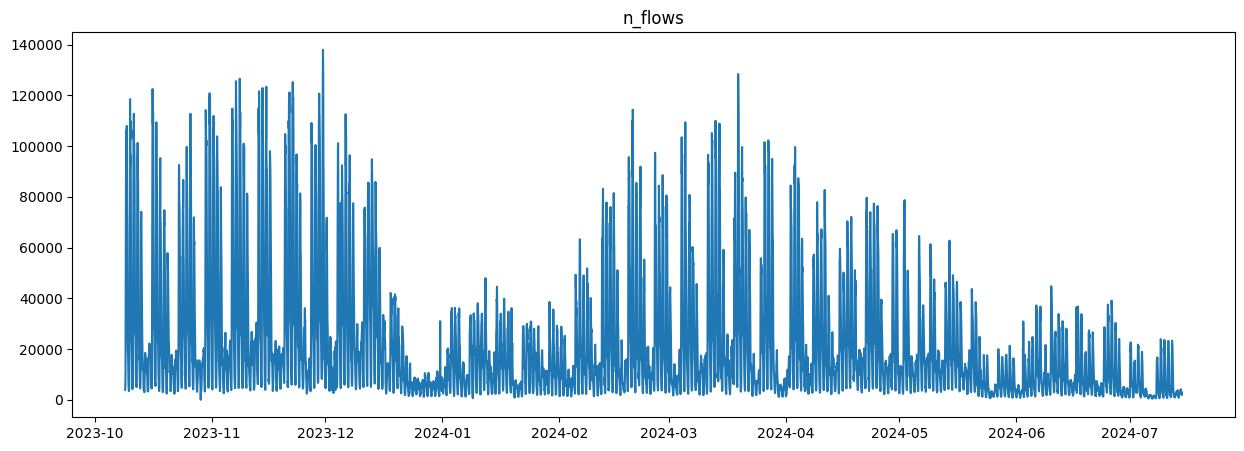

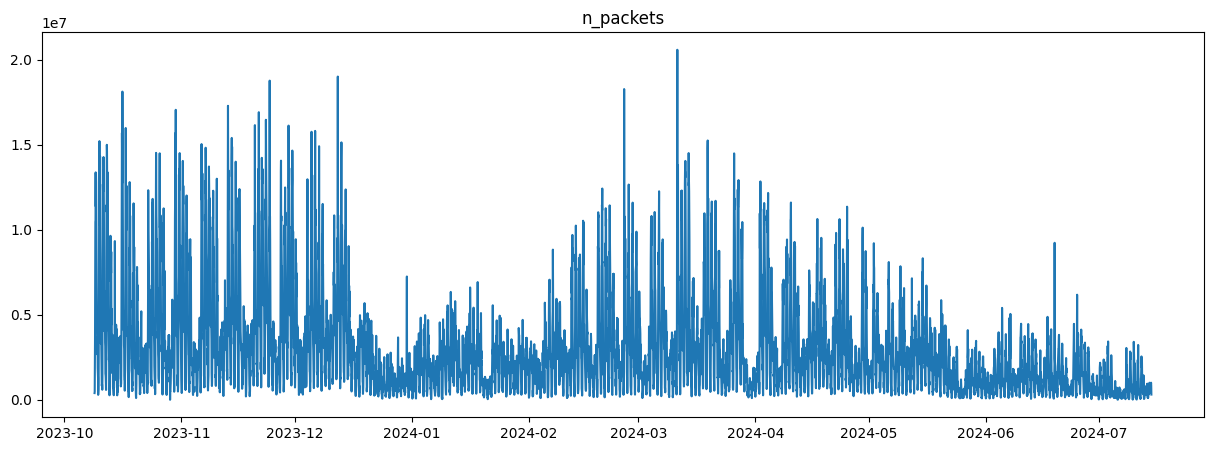

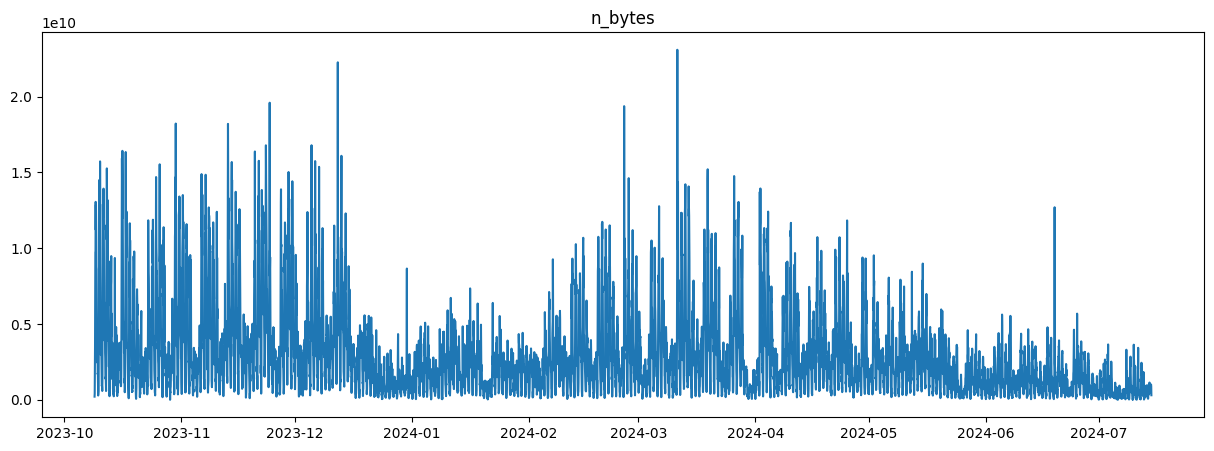

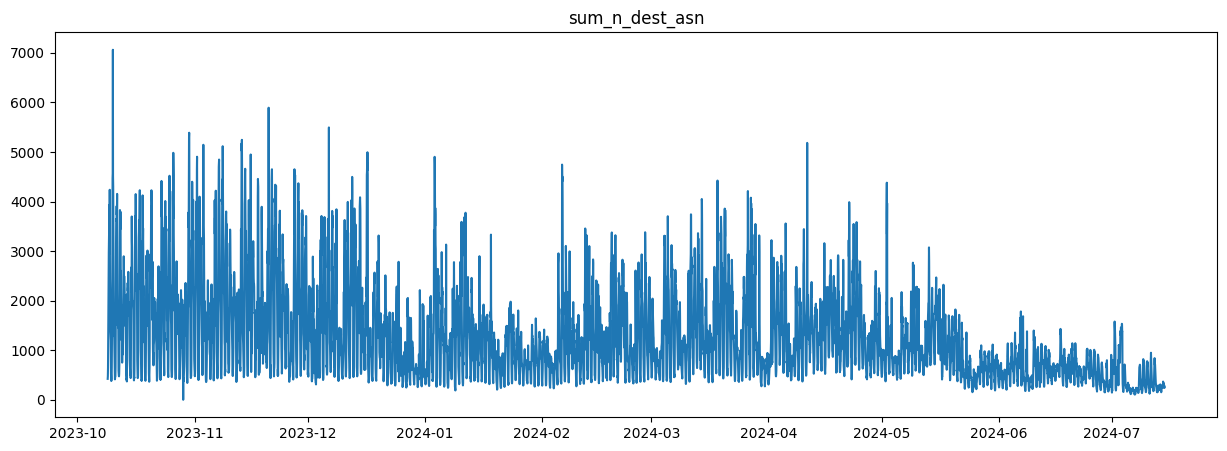

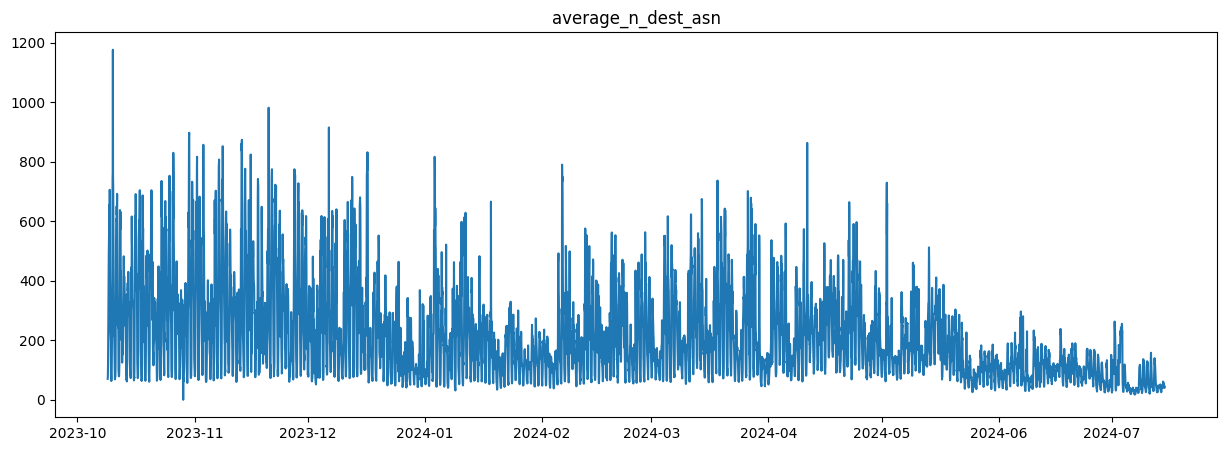

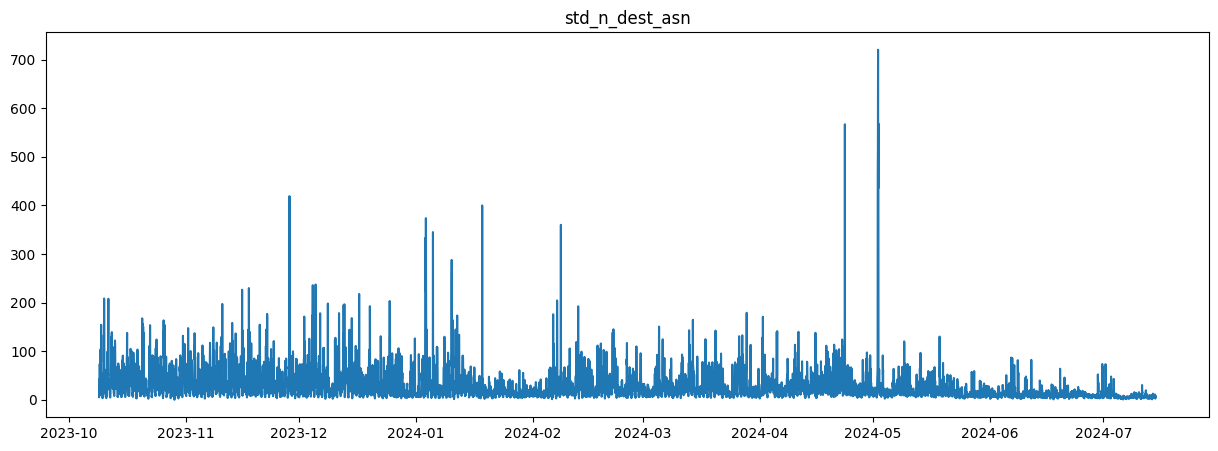

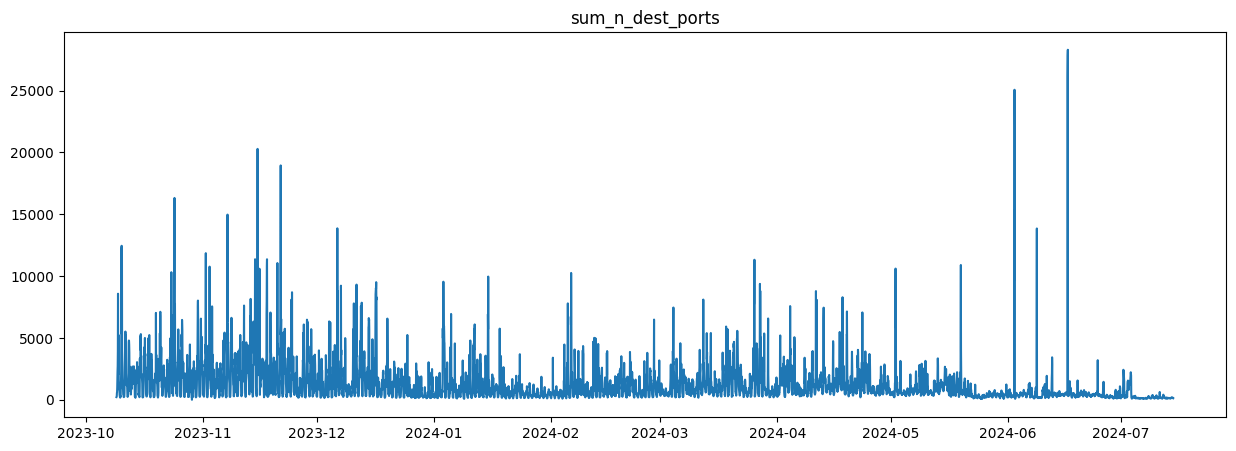

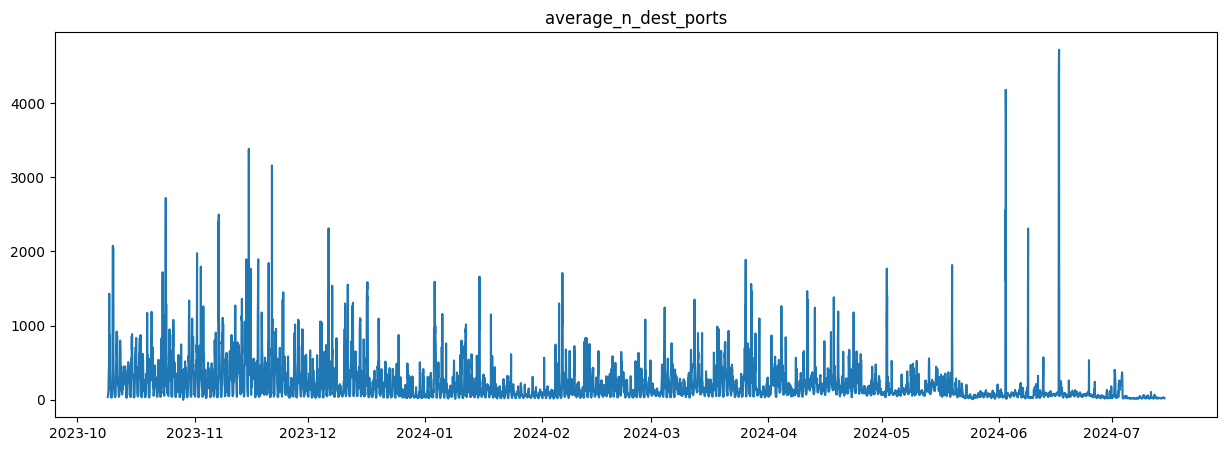

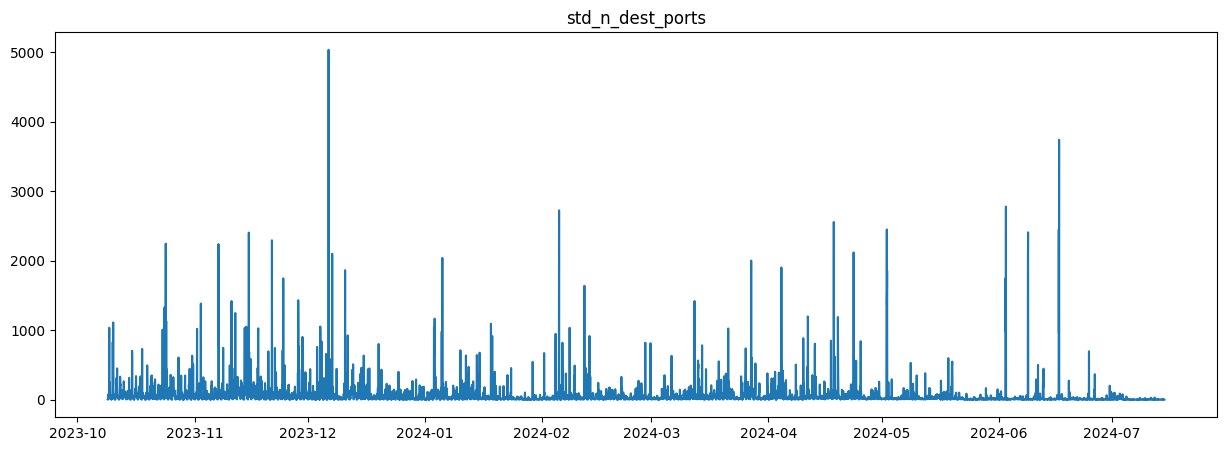

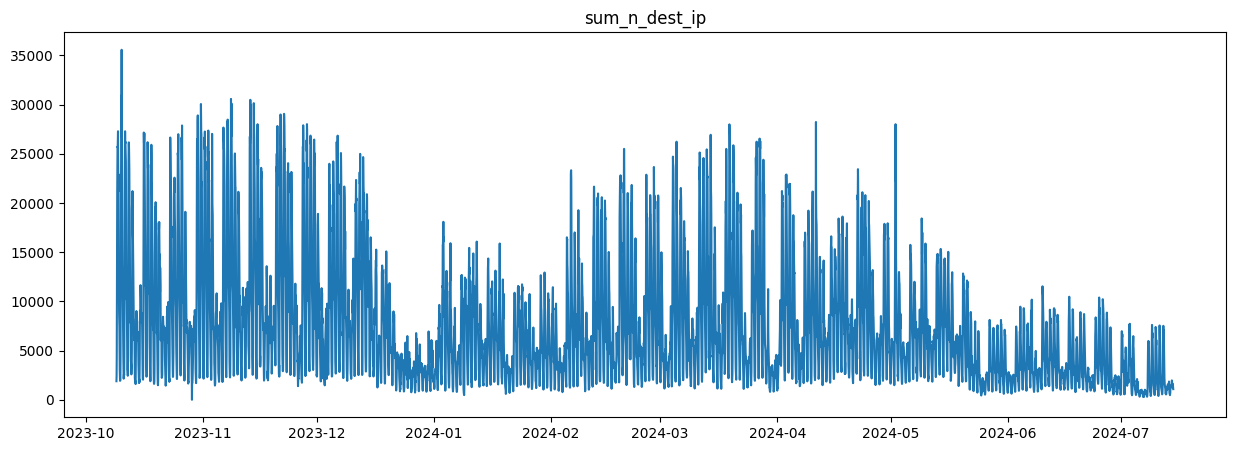

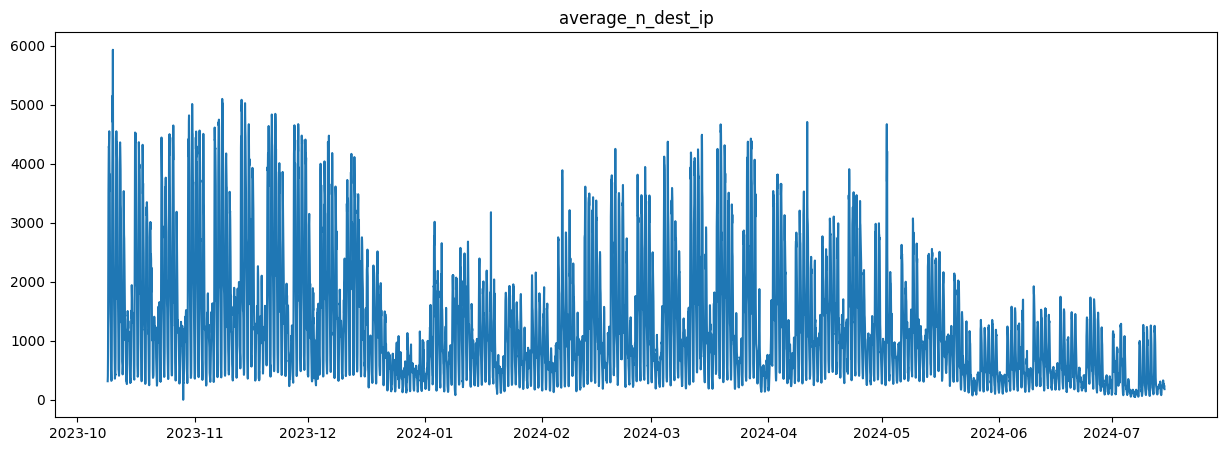

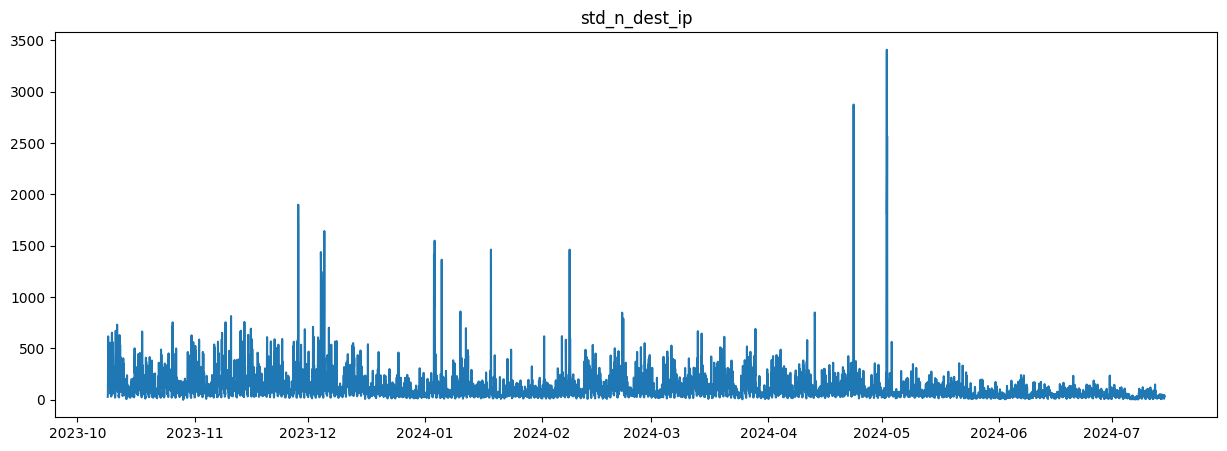

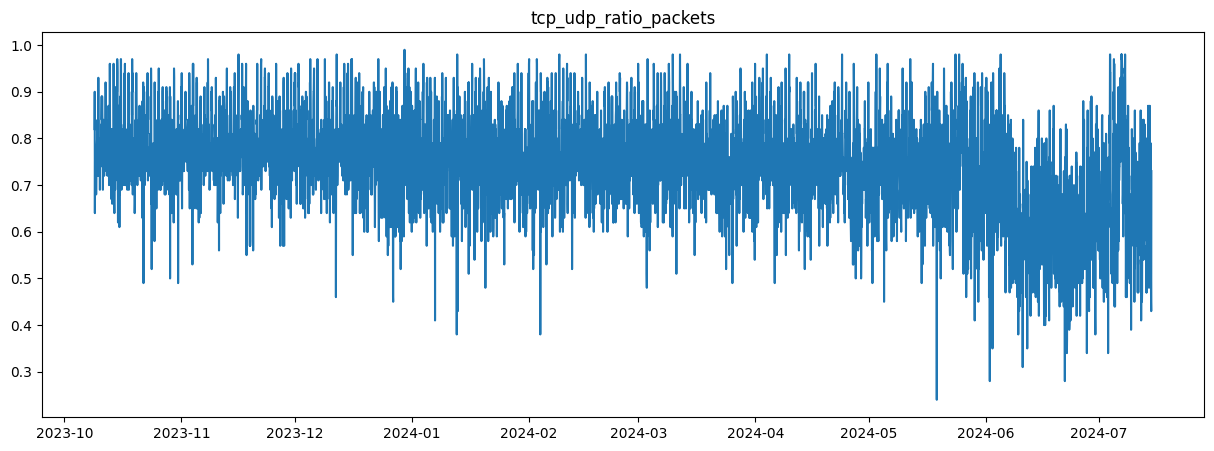

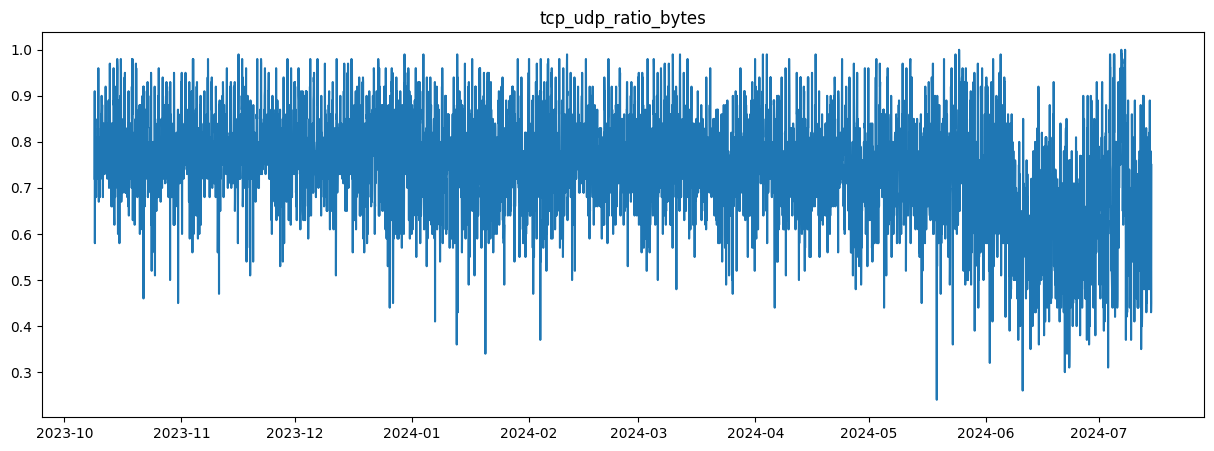

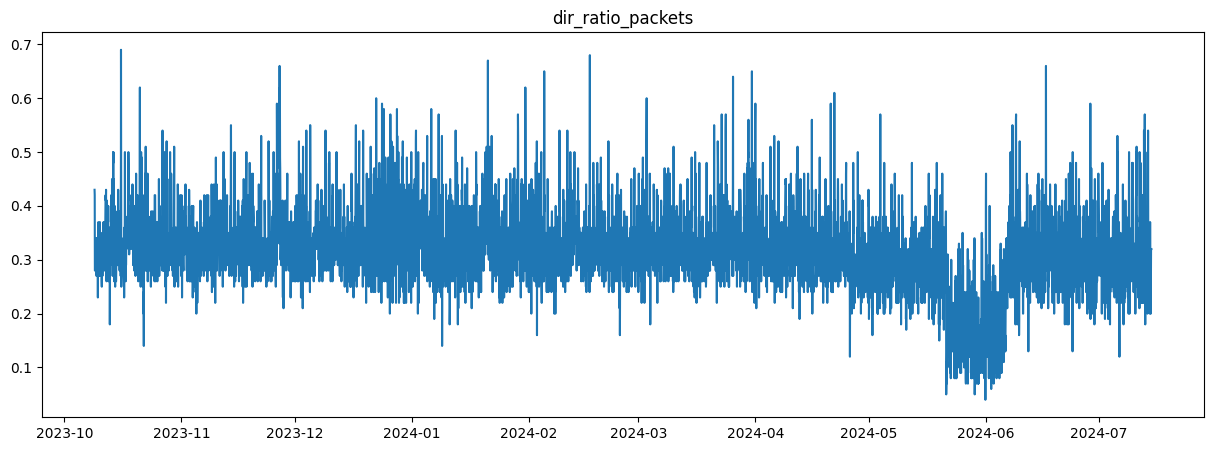

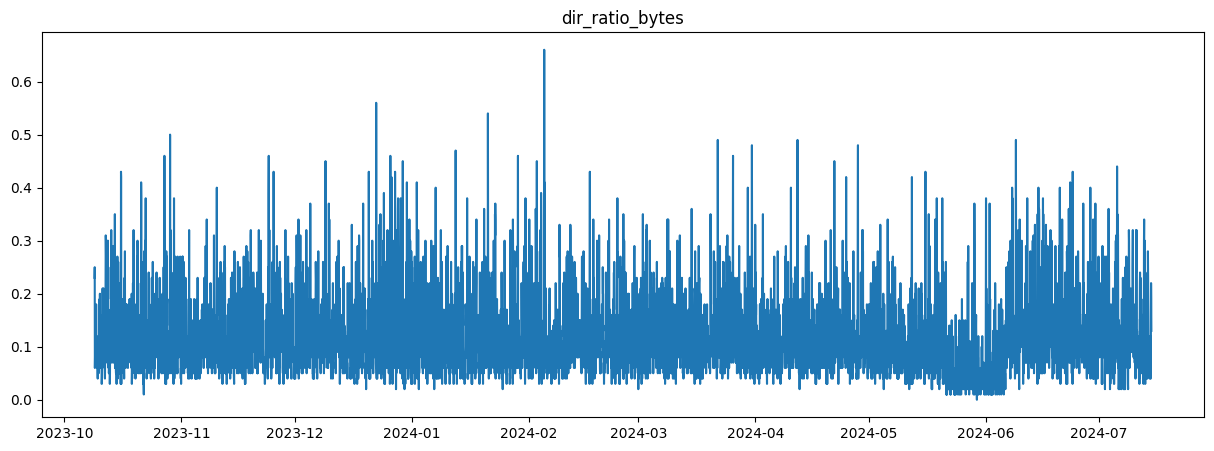

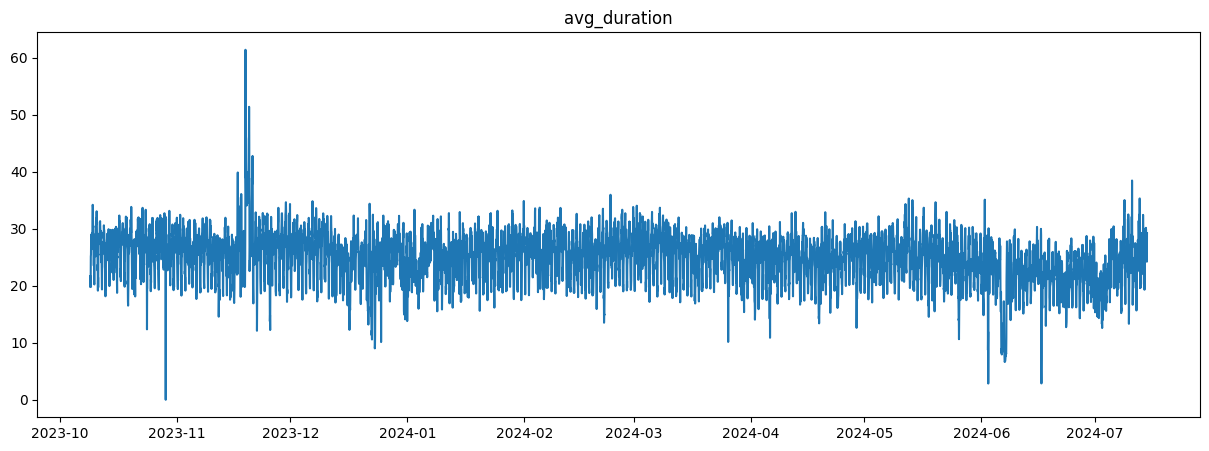

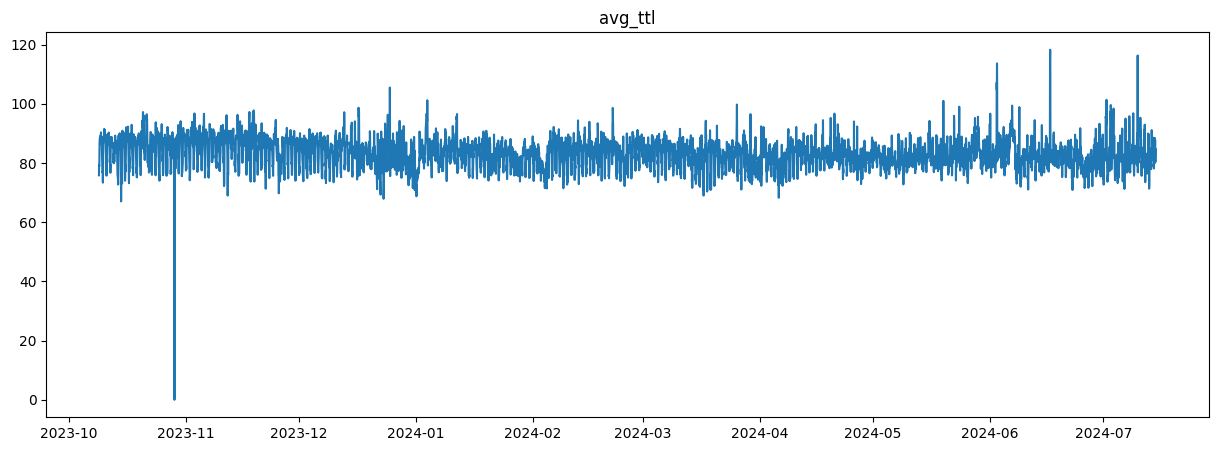

In [38]:
for metric in df.keys():
    if metric == 'time' or metric == 'id_time':
        continue
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(df.time, df[metric])
    plt.title(metric)
    plt.show()
    plt.close()

## Example of modeling time series metric 'n_flows' with SARIMA

Train data ... first month


Test data  ... one week after the month

In [39]:
ORDER = (1, 1, 1)
SEASONAL_ORDER = (1, 1, 1, 168)
    
TRAINING_PERIOD = 744
TESTING_PERIOD = 168
    
TS_METRIC = 'n_flows'

In [40]:
train_df = df[df.id_time < TRAINING_PERIOD]
train_data = train_df[TS_METRIC].to_numpy()        

In [12]:
model = SARIMAX(train_data, order=ORDER, seasonal_order=SEASONAL_ORDER)
results = model.fit(disp=False)

In [13]:
forecasts = list(results.forecast(steps=TESTING_PERIOD))

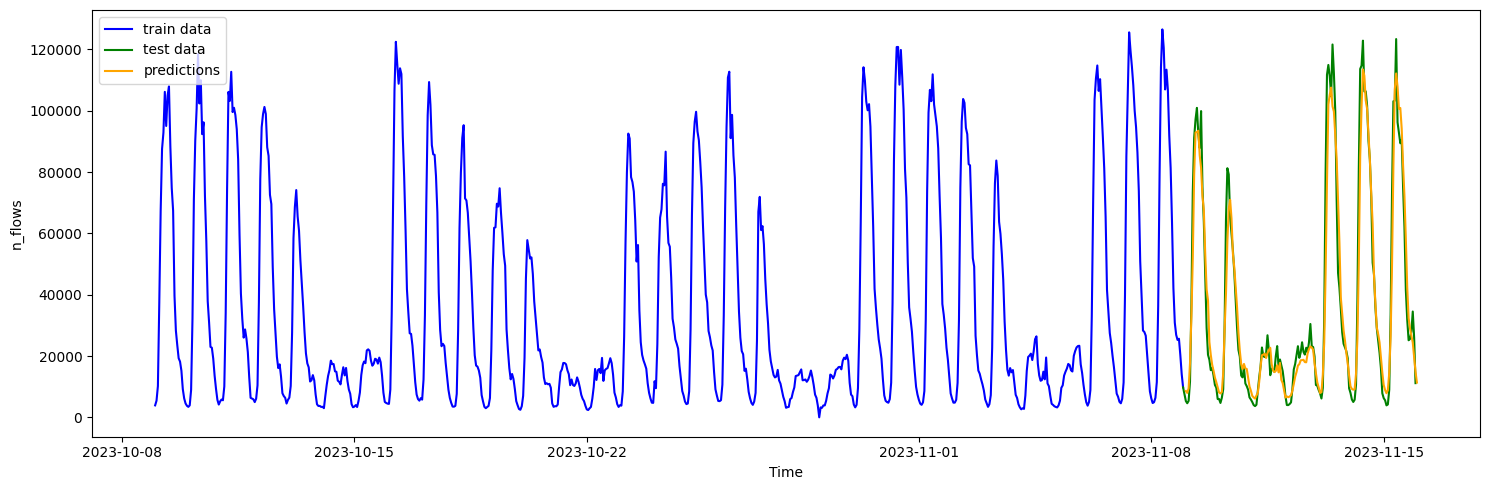

In [28]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df[df.id_time < TRAINING_PERIOD].time, df[df.id_time < TRAINING_PERIOD][TS_METRIC], color='blue', label='train data')
tmp = df[df.id_time >= TRAINING_PERIOD - 1]
ax.plot(tmp[tmp.id_time < TRAINING_PERIOD + TESTING_PERIOD].time, tmp[tmp.id_time < TRAINING_PERIOD + TESTING_PERIOD][TS_METRIC], color='green', label='test data')
tmp = df[df.id_time > TRAINING_PERIOD]
ax.plot(tmp[tmp.id_time <= TRAINING_PERIOD + TESTING_PERIOD].time, forecasts, color='orange', label='predictions')
plt.legend()
plt.xlabel("Time")
plt.ylabel(TS_METRIC)
plt.tight_layout()
plt.show()

## Example of modeling time series metric 'n_flows' with SARIMA with retraining

Train data ... first month


Test data  ... one week after the month

In [41]:
tmp_index = 0
predictions = []
while tmp_index <= df.id_time.max() - TRAINING_PERIOD:
    train_df = df[df.id_time < tmp_index + TRAINING_PERIOD]
    train_df = train_df[train_df.id_time >= tmp_index]
    train_data = train_df[TS_METRIC].to_numpy()
        
    model = SARIMAX(train_data, order=ORDER, seasonal_order=SEASONAL_ORDER)
    results = model.fit(disp=False)
        
    predictions += list(results.forecast(steps=TESTING_PERIOD))
    tmp_index += TESTING_PERIOD

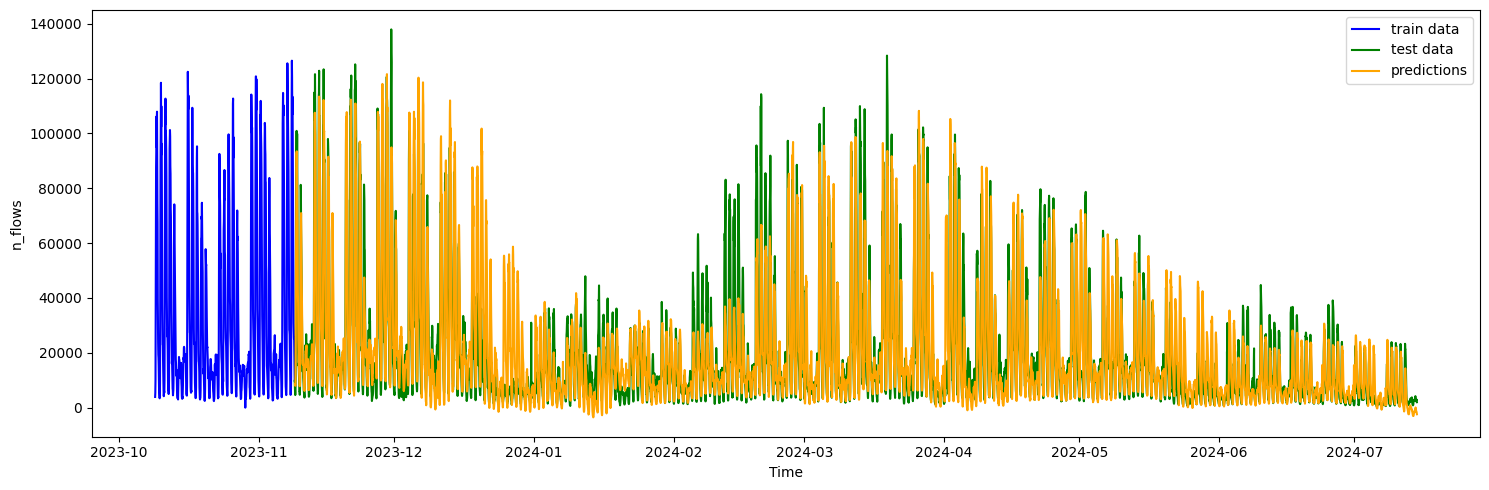

In [46]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df[df.id_time < TRAINING_PERIOD].time, df[df.id_time < TRAINING_PERIOD][TS_METRIC], color='blue', label='train data')
tmp = df[df.id_time >= TRAINING_PERIOD - 1]
ax.plot(tmp.time, tmp[TS_METRIC], color='green', label='test data')
tmp = df[df.id_time > TRAINING_PERIOD]
ax.plot(tmp.time, predictions[:len(tmp.time)], color='orange', label='predictions')
plt.legend()
plt.xlabel("Time")
plt.ylabel(TS_METRIC)
plt.tight_layout()
plt.show()

#### Evaluation metrics

Evaluation metrics are critical in assessing the performance of regression models. Below are some commonly used metrics in regression analysis.

##### RMSE

**Root Mean Squared Error (RMSE)** is a measure of the differences between predicted and actual values. It gives an idea of how far the residuals (the differences between actual and predicted values) are from zero. The RMSE is especially useful when large errors are particularly undesirable.

The RMSE is defined as:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Where:
- $ n $ is the number of observations
- $ y_i $ is the actual value
- $ \hat{y}_i $ is the predicted value

##### SMAPE

**Symmetric Mean Absolute Percentage Error (SMAPE)** is an accuracy measure based on percentage errors. It is useful when you want to express errors as a percentage, and it is symmetric, meaning it treats overestimations and underestimations equally.

The SMAPE is defined as:

$$
\text{SMAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{(|y_i| + |\hat{y}_i|)/2}
$$

Where:
- $ n $ is the number of observations
- $ y_i $ is the actual value
- $ \hat{y}_i $ is the predicted value

##### R2 score

**R-squared ($ R^2 $)** is a statistical measure that indicates how well the regression predictions approximate the actual data points. It provides the proportion of the variance in the dependent variable that is predictable from the independent variables.

The $ R^2 $ score is defined as:

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

Where:
- $ n $ is the number of observations
- $ y_i $ is the actual value
- $ \hat{y}_i $ is the predicted value
- $ \bar{y} $ is the mean of the actual values

The $ R^2 $ value ranges from 0 to 1, with 1 indicating that the model perfectly predicts the data and 0 indicating that the model does not explain any of the variance in the data.


In [51]:
from sklearn.metrics import r2_score, root_mean_squared_error

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

tmp = df[df.id_time >= TRAINING_PERIOD - 1]
results_rmse = root_mean_squared_error(tmp[TS_METRIC], predictions[:len(tmp[TS_METRIC])])
results_r2_score = r2_score(tmp[TS_METRIC], predictions[:len(tmp[TS_METRIC])])
results_smape = smape(tmp[TS_METRIC], predictions[:len(tmp[TS_METRIC])])

print(f"    RMSE: {results_rmse}")
print(f"   SMAPE: {results_smape}")
print(f"R2 Score: {results_r2_score}")

    RMSE: 12095.789321447739
   SMAPE: 46.535934278626584
R2 Score: 0.7214245931469666


# Process all time series from selected dataset


### Example case 1: using the file hierarchy

The example of dataset usa in following example is Institutions part dataset.

In [52]:
path = f"{DATASET_PATH}{INSTITUTIONS}{AGGREAGATIONS[index]}"
os.listdir(path)[:5]

['0.csv', '1.csv', '10.csv', '100.csv', '101.csv']

In [53]:
for file in os.listdir(path):
    df = pd.read_csv(f"{path}{file}")
    df = fill_missing(df, df_times.id_time)
    df['time'] = df_times['time']
    df = df[['time'] + df.keys().drop('time').to_list()]
    
    # Process with model here 
    

The example of the dataset use in following example is Full IP addresses part 

In [54]:
path = f"{DATASET_PATH}{FULL_IP_ADDRESSES}{AGGREAGATIONS[index]}"
os.listdir(path)[:5]

['1', '10', '11', '2', '3']

In [56]:
for id_folder in os.listdir(path):
    folder_path = f"{path}/{id_folder}/"
    for file in os.listdir(folder_path):
        df = pd.read_csv(f"{folder_path}{file}")
        df = fill_missing(df, df_times.id_time)
        df['time'] = df_times['time']
        df = df[['time'] + df.keys().drop('time').to_list()]
        
        # Process with model here 
        

### Example case 2: using the identificators.csv fiels

The example of dataset usa in following example is Institutions part dataset.

In [57]:
df_identificators =  pd.read_csv(f"{DATASET_PATH}{INSTITUTIONS}identificators.csv")
df_identificators

,id_institution
0,0
1,1
2,2
3,3
4,4
...,...
278,280
279,281
280,282
281,283


In [70]:
path = f"{DATASET_PATH}{INSTITUTIONS}{AGGREAGATIONS[index]}"
for id_institution in df_identificators.id_institution.values:
    df = pd.read_csv(f"{path}/{id_institution}.csv")
    df = fill_missing(df, df_times.id_time)
    df['time'] = df_times['time']
    df = df[['time'] + df.keys().drop('time').to_list()]
    
    # Process with model here 

The example of the dataset use in following example is Full IP addresses part 

In [61]:
df_identificators =  pd.read_csv(f"{DATASET_PATH}{FULL_IP_ADDRESSES}identificators.csv")
df_identificators

,id_ip,id_ip_folder
0,3,1
1,5,1
2,10,1
3,11,1
4,12,1
...,...,...
275119,2051841,11
275120,2051849,11
275121,2051850,11
275122,2051853,11


In [69]:
path = f"{DATASET_PATH}{FULL_IP_ADDRESSES}{AGGREAGATIONS[index]}"
for index, row in df_identificators.iterrows():
    df = pd.read_csv(f"{path}{row.id_ip_folder}/{row.id_ip}.csv")
    df = fill_missing(df, df_times.id_time)
    df['time'] = df_times['time']
    df = df[['time'] + df.keys().drop('time').to_list()]
    
    # Process with model here 